In [38]:
import numpy as np
import pandas as pd

We start by conducting a basic EDA on the data of one station , in this case station_0. 

In [40]:
station_0_data = pd.read_csv("Data_csv/Station_00.csv")

In [41]:
station_0_data.head()

,Year,Month,Day,T obs,T mod,P obs,P mod,H obs,H mod,W obs,W mod,SW obs,SW mod
0,2001,1,1,NaN,0.97,NaN,0.00,NaN,32.22,4.95,2.67,NaN,77.18
1,2001,1,2,NaN,4.20,NaN,0.41,NaN,79.75,3.01,2.41,NaN,69.72
2,2001,1,3,NaN,1.47,NaN,2.39,NaN,83.82,3.15,3.00,NaN,55.23
3,2001,1,4,NaN,3.07,NaN,4.32,NaN,67.58,5.13,3.73,NaN,73.89
4,2001,1,5,NaN,4.65,NaN,0.74,NaN,59.15,6.84,5.14,NaN,74.07


In [42]:
station_0_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    3287 non-null   int64  
 1   Month   3287 non-null   int64  
 2   Day     3287 non-null   int64  
 3   T obs   1331 non-null   float64
 4   T mod   3287 non-null   float64
 5   P obs   0 non-null      float64
 6   P mod   3287 non-null   float64
 7   H obs   1331 non-null   float64
 8   H mod   3287 non-null   float64
 9   W obs   3024 non-null   float64
 10  W mod   3287 non-null   float64
 11  SW obs  0 non-null      float64
 12  SW mod  3287 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 334.0 KB


# Data visualization

In [579]:
seasons = ["Spring","Summer","Fall","Winter"]
label_season = lambda m : seasons[((m + 9) % 12) //3]

In [583]:
for i in range(1,13):
    print(f"{i},{label_season(i)}")

1,Winter
2,Winter
3,Spring
4,Spring
5,Spring
6,Summer
7,Summer
8,Summer
9,Fall
10,Fall
11,Fall
12,Winter


In [44]:
import datetime

In [926]:
pd.options.mode.chained_assignment = None
station_0_data_augmented = station_0_data[::]
station_0_data_augmented["full_date"] = pd.to_datetime(station_0_data_augmented[["Year","Month","Day"]])

station_0_data_indexed = station_0_data_augmented.set_index("full_date")
station_0_data_indexed["season"] = station_0_data_indexed["Month"].map(label_season)
station_0_data_indexed.head()


,Year,Month,Day,T obs,T mod,P obs,P mod,H obs,H mod,W obs,W mod,SW obs,SW mod,season
full_date,,,,,,,,,,,,,,
2001-01-01,2001,1,1,NaN,0.97,NaN,0.00,NaN,32.22,4.95,2.67,NaN,77.18,Winter
2001-01-02,2001,1,2,NaN,4.20,NaN,0.41,NaN,79.75,3.01,2.41,NaN,69.72,Winter
2001-01-03,2001,1,3,NaN,1.47,NaN,2.39,NaN,83.82,3.15,3.00,NaN,55.23,Winter
2001-01-04,2001,1,4,NaN,3.07,NaN,4.32,NaN,67.58,5.13,3.73,NaN,73.89,Winter
2001-01-05,2001,1,5,NaN,4.65,NaN,0.74,NaN,59.15,6.84,5.14,NaN,74.07,Winter


First question : how does the modeled values fair against the observed data ? 

We first explore this question at a glance, looking at lineplots for each modeled value and pair of observed and modeled data. 

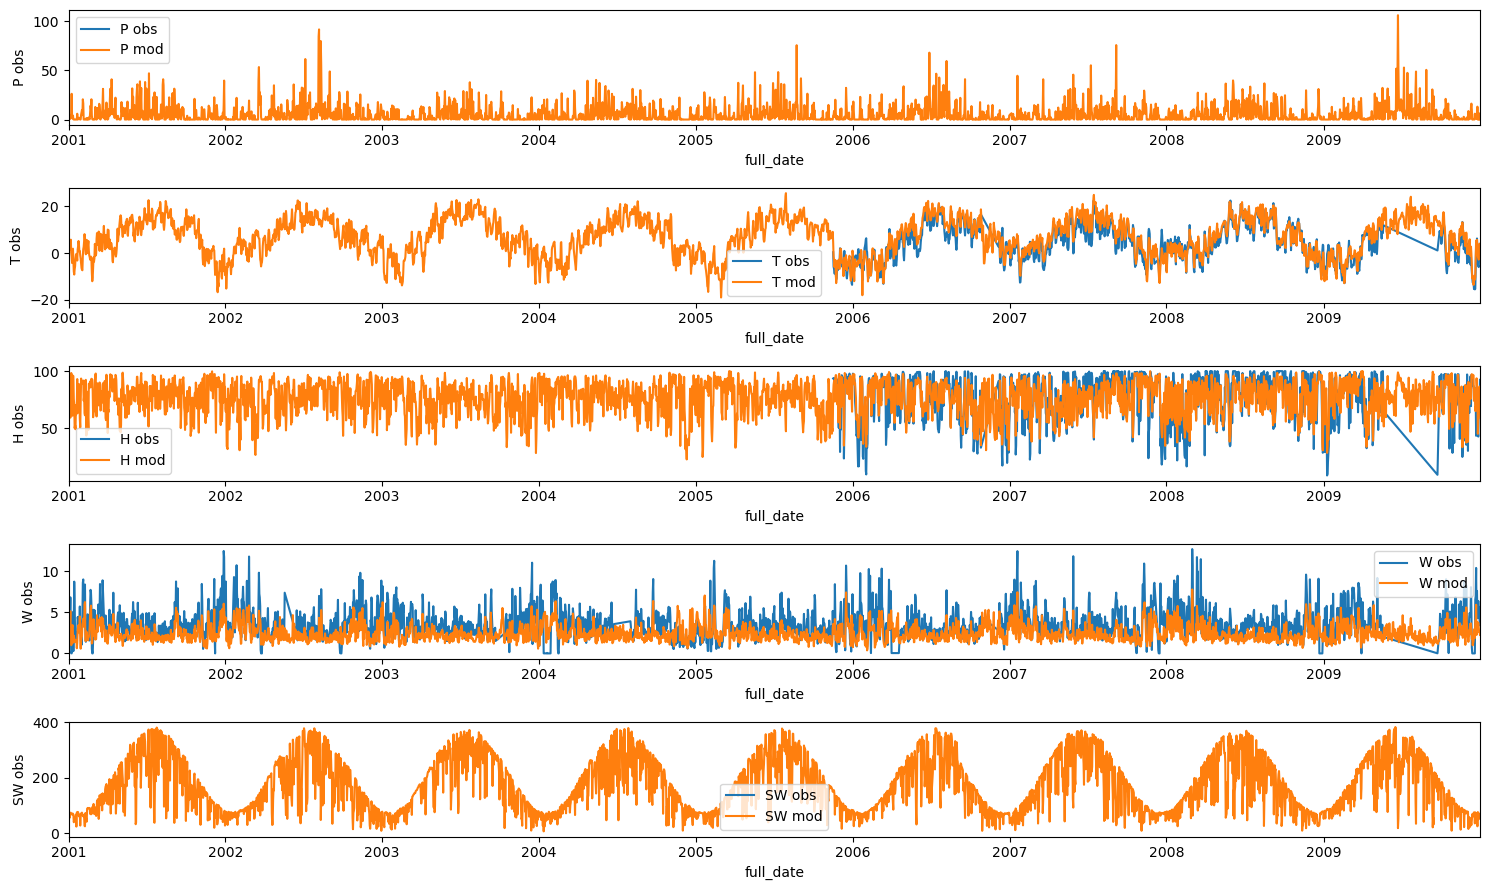

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt
targets = ["P","T","H","W","SW"]
obs_targets = [t + " obs" for t in targets]
mod_targets = [t +  " mod" for t in targets]

plt.figure(figsize=(15,9))
for idx in range(len(targets)):
    ax = plt.subplot(len(targets), 1, idx + 1)
    sns.lineplot(x=station_0_data_augmented["full_date"], 
             y=station_0_data_augmented[obs_targets[idx]],ax = ax,label=f"{obs_targets[idx]}")
    plt.xlim(station_0_data_augmented["full_date"].min(),station_0_data_augmented["full_date"].max())
    sns.lineplot(x=station_0_data_augmented["full_date"], 
             y=station_0_data_augmented[mod_targets[idx]],ax = ax,label=f"{mod_targets[idx]}")

    plt.tight_layout()
plt.show()
    

As seen above, some data is missing. For instance, no data can be found for the values of the precipitations for station 0. As for the temperature, the data there is no value before the last third of 2005. 

Notwithstanding, on the data we have i.e 2006 onwards (except a period of time in mid 2009), we observe that the modeled temperature is overall somewhat close to the observed temperature. However, there seems to be visually speaking a slight shift / bias upwards from the model with respect to the observed data. 

Let us investigate this further.

## Missing values : can we try to fill values by doing an average among day-month combinations?


In [956]:
station_0_data_indexed.apply(lambda row : mean_T_obs if ((row["Month"] == 1 and row["Day"] == ) and pd.isna(row["T obs"])) else row["T obs"],axis=1)

full_date
2001-01-01    0.158
2001-01-02      NaN
2001-01-03      NaN
2001-01-04      NaN
2001-01-05      NaN
              ...  
2009-12-27   -5.390
2009-12-28   -5.990
2009-12-29   -0.550
2009-12-30    2.650
2009-12-31   -0.200
Length: 3287, dtype: float64

In [962]:
v = station_0_data_indexed.groupby(["Month","Day"])
station_0_data_indexed_filled = station_0_data_indexed[:]
for index,group in v :
    mean_T_obs = group["T obs"].mean()
    station_0_data_indexed_filled["T obs"] = station_0_data_indexed_filled.apply(lambda row : mean_T_obs if ((row["Month"] == index[0] and row["Day"] == index[1]) and pd.isna(row["T obs"])) else row["T obs"],axis=1)

In [964]:
station_0_data_indexed_filled.head()

,Year,Month,Day,T obs,T mod,P obs,P mod,H obs,H mod,W obs,W mod,SW obs,SW mod,season
full_date,,,,,,,,,,,,,,
2001-01-01,2001,1,1,-2.7100,0.97,NaN,0.00,NaN,32.22,4.95,2.67,NaN,77.18,Winter
2001-01-02,2001,1,2,-5.5575,4.20,NaN,0.41,NaN,79.75,3.01,2.41,NaN,69.72,Winter
2001-01-03,2001,1,3,-4.8150,1.47,NaN,2.39,NaN,83.82,3.15,3.00,NaN,55.23,Winter
2001-01-04,2001,1,4,-2.3850,3.07,NaN,4.32,NaN,67.58,5.13,3.73,NaN,73.89,Winter
2001-01-05,2001,1,5,-2.8550,4.65,NaN,0.74,NaN,59.15,6.84,5.14,NaN,74.07,Winter


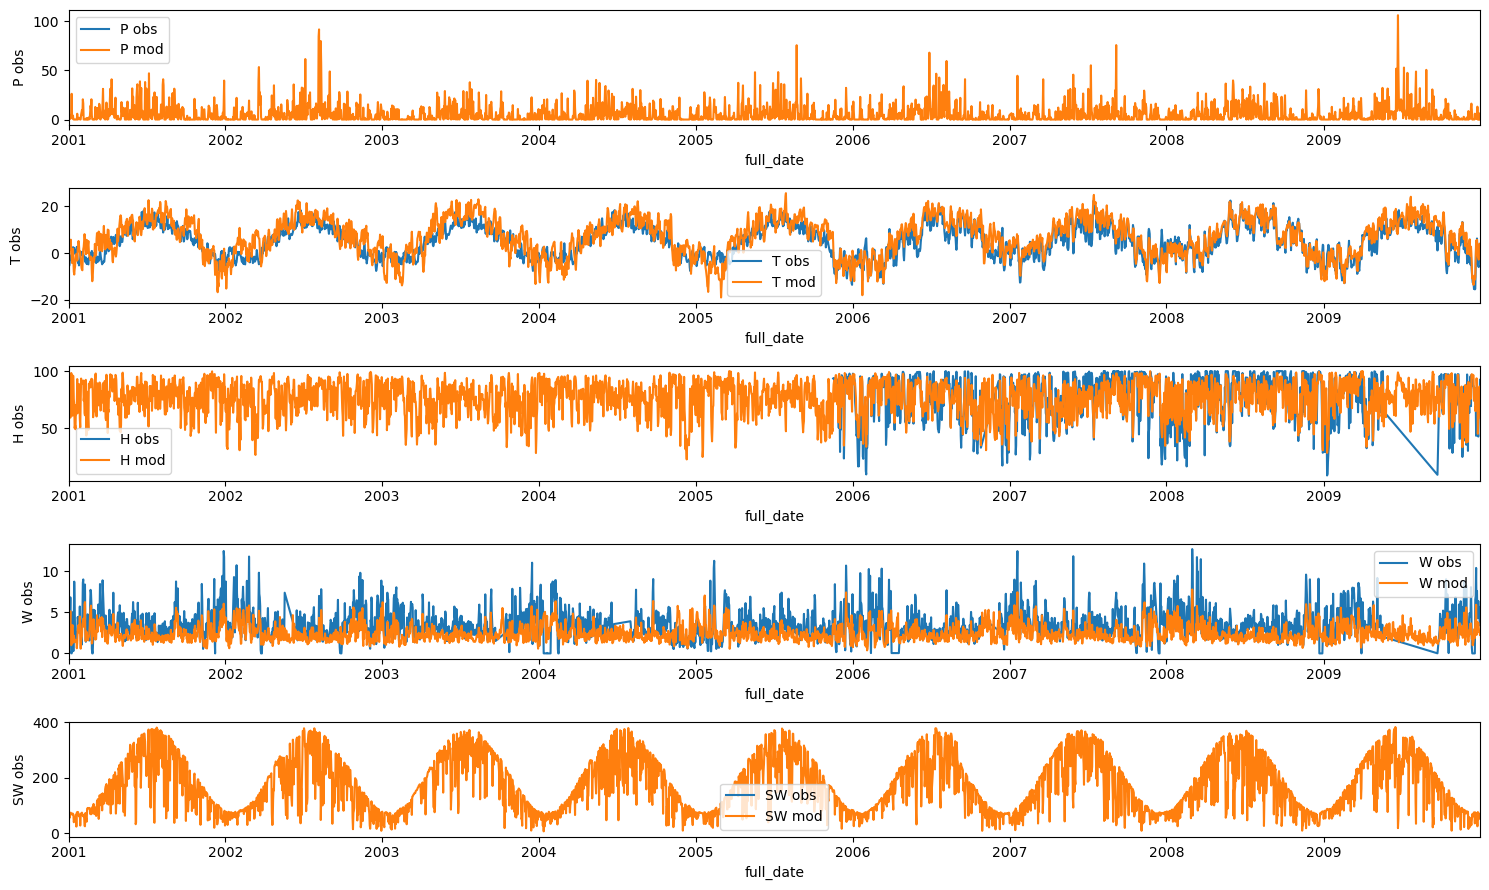

In [970]:
import seaborn as sns
import matplotlib.pyplot as plt
targets = ["P","T","H","W","SW"]
obs_targets = [t + " obs" for t in targets]
mod_targets = [t +  " mod" for t in targets]

plt.figure(figsize=(15,9))
for idx in range(len(targets)):
    ax = plt.subplot(len(targets), 1, idx + 1)
    sns.lineplot(x=station_0_data_indexed_filled.index, 
             y=station_0_data_indexed_filled[obs_targets[idx]],ax = ax,label=f"{obs_targets[idx]}")
    plt.xlim(station_0_data_augmented["full_date"].min(),station_0_data_augmented["full_date"].max())
    sns.lineplot(x=station_0_data_augmented["full_date"], 
             y=station_0_data_augmented[mod_targets[idx]],ax = ax,label=f"{mod_targets[idx]}")

    plt.tight_layout()
plt.show()
    

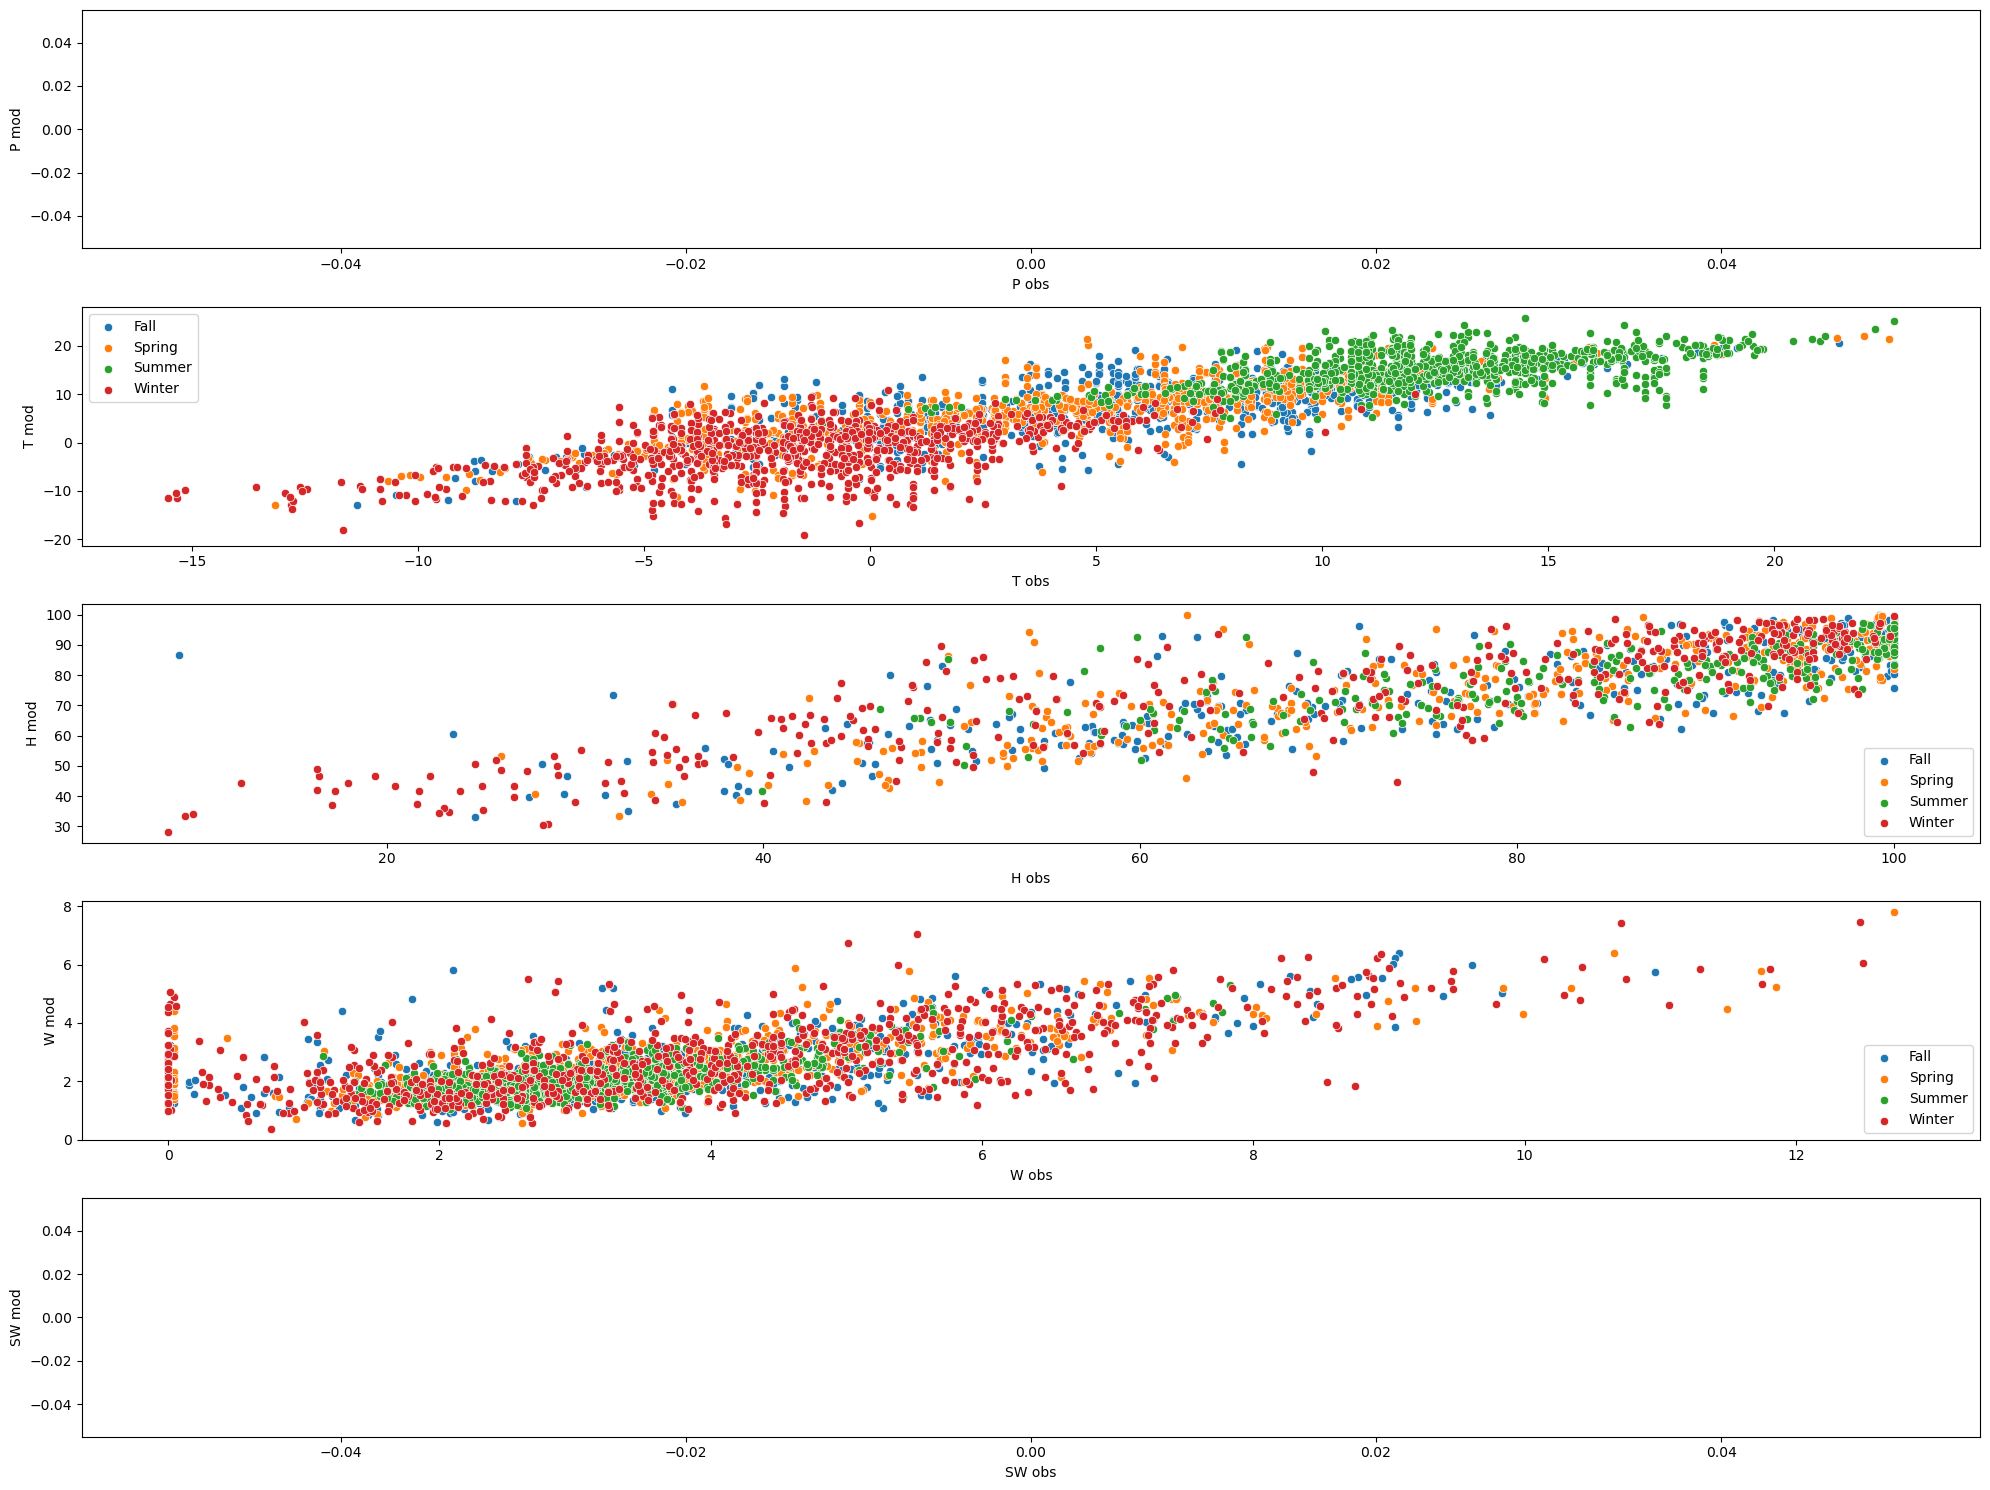

In [972]:
plt.figure(figsize=(20,15))
for idx in range(len(targets)):
    ax = plt.subplot(len(targets), 1, idx+1)
    group_seasons = station_0_data_indexed_filled.groupby("season")
    for label,table in group_seasons:
        sns.scatterplot(x=table[obs_targets[idx]], y = table[mod_targets[idx]],label=f"{label}")

    ax.set_xlabel(f"{obs_targets[idx]}")
    ax.set_ylabel(f"{mod_targets[idx]}")
    
    plt.tight_layout()
plt.savefig("station_0.png")
plt.show()


In [974]:
from sklearn.metrics import r2_score


for idx in range(len(targets)):
    try:
        obs  =  station_0_data_indexed_filled.loc[:,obs_targets[idx]]
        mod  = station_0_data_indexed_filled.loc[:,mod_targets[idx]]
        mod, obs = obs.align(mod, join="inner") #aligns values by date
        mask =pd.isna(station_0_data_indexed_filled[obs_targets[idx]]) & (pd.isna(station_0_data_indexed_filled[mod_targets[idx]]) == False) 
        mask =  ~mask #mask for detecting all valid pair of data
        print(f"R2 score ({targets[idx]}): {r2_score(mod[mask],
                                                    obs[mask])}")
    except Exception as e :
        print(e)

Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
R2 score (T): 0.5563069931461928
R2 score (H): 0.6833428714746874
R2 score (W): 0.10070915631632149
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


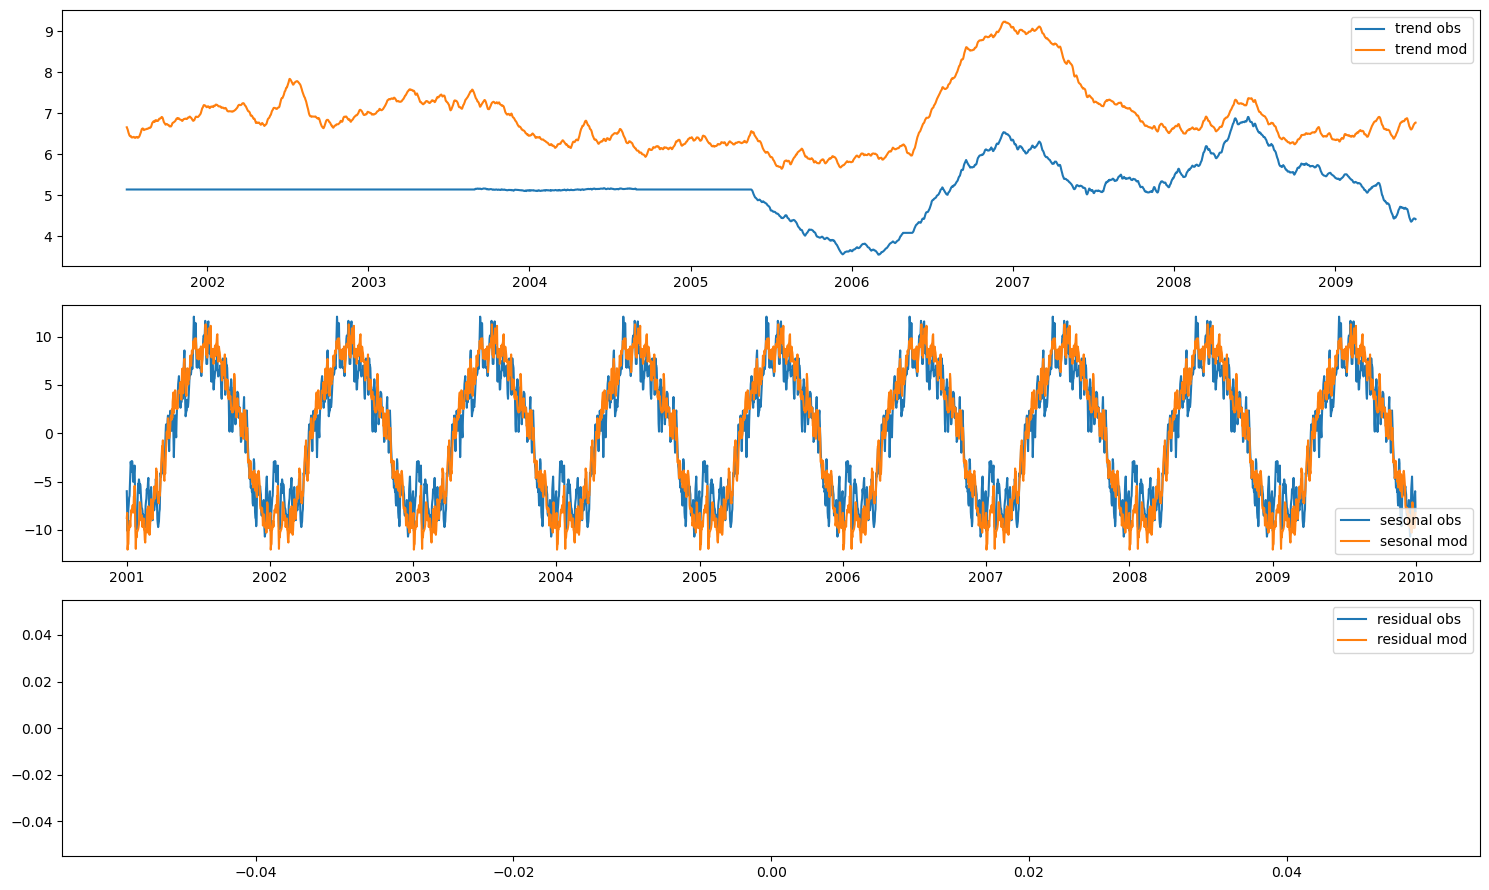

In [977]:
from statsmodels.tsa.seasonal import seasonal_decompose


data  = station_0_data_indexed_filled[pd.isna(station_0_data_indexed_filled["T obs"]) == False].loc[:,["T obs","T mod"]]
cleaned_T_obs,cleaned_T_mod = data.loc[:,"T obs"], data.loc[:,"T mod"]
decomposition = seasonal_decompose(cleaned_T_obs, model = "additive", period=365)

trend = pd.DataFrame(decomposition.trend,columns=["trend"])
seasonal = pd.DataFrame(decomposition.seasonal,columns=["seasonal"])
residual = pd.DataFrame(decomposition.resid,columns=["residual"])

objects = {"trend":trend,"sesonal":seasonal,"residual":residual}

decomposition = seasonal_decompose(cleaned_T_mod, model = "additive", period=365)

trend = pd.DataFrame(decomposition.trend,columns=["trend"])
seasonal = pd.DataFrame(decomposition.seasonal,columns=["seasonal"])
residual = pd.DataFrame(decomposition.resid,columns=["residual"])




objects2 = {"trend":trend,"sesonal":seasonal,"residual":residual}

plt.figure(figsize=(15,9))
idx = 1
group_seasons = station_0_data_indexed.groupby("season")
for key,value in  objects.items():
    ax = plt.subplot(3, 1, idx)
    idx += 1
    plt.plot(value, label=key+ " obs")
    plt.plot(objects2[key], label= key + " mod") 
    plt.legend()
    plt.tight_layout()
plt.show()

Clearly, we see that the trend of the modeled temperature is constantly higher that that of the observed temperature. This indicates that the model is likely biased towards higher value of the temperature.

# Our task

Our task is to produce a function that corrects the bias of the model. 
A sensible way to do so is to first produce a function producing the bias of the model, then reconstruct then correct the model by adding the bias to the modeled value. 

Hence, our task is to predict the bias of the model given its output. 

For starter, let's  exercise by constructing a function correcting the temperature model in station_0.



## Correcting the temperature model of station 0

## To Do:
- compute residuals
- visualize residuals
- create a linear model (polynomial fit?)
- NN (FF)
- RNN


### Computing residuals

In [979]:
for idx in range(len(targets)):
    station_0_data_indexed_filled[f"Delta_{targets[idx]}"] = station_0_data_indexed_filled[obs_targets[idx]] - station_0_data_indexed_filled[mod_targets[idx]]

In [983]:
station_0_data_indexed_filled.head(-5)

,Year,Month,Day,T obs,T mod,P obs,P mod,H obs,H mod,W obs,W mod,SW obs,SW mod,season,Delta_P,Delta_T,Delta_H,Delta_W,Delta_SW
full_date,,,,,,,,,,,,,,,,,,,
2001-01-01,2001,1,1,-2.7100,0.97,NaN,0.00,NaN,32.22,4.95,2.67,NaN,77.18,Winter,NaN,-3.6800,NaN,2.28,NaN
2001-01-02,2001,1,2,-5.5575,4.20,NaN,0.41,NaN,79.75,3.01,2.41,NaN,69.72,Winter,NaN,-9.7575,NaN,0.60,NaN
2001-01-03,2001,1,3,-4.8150,1.47,NaN,2.39,NaN,83.82,3.15,3.00,NaN,55.23,Winter,NaN,-6.2850,NaN,0.15,NaN
2001-01-04,2001,1,4,-2.3850,3.07,NaN,4.32,NaN,67.58,5.13,3.73,NaN,73.89,Winter,NaN,-5.4550,NaN,1.40,NaN
2001-01-05,2001,1,5,-2.8550,4.65,NaN,0.74,NaN,59.15,6.84,5.14,NaN,74.07,Winter,NaN,-7.5050,NaN,1.70,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-22,2009,12,22,3.7400,5.35,NaN,1.37,43.20,65.47,10.42,5.93,NaN,71.02,Winter,NaN,-1.6100,-22.27,4.49,NaN
2009-12-23,2009,12,23,-0.3400,0.83,NaN,0.69,85.78,93.70,4.30,2.25,NaN,63.33,Winter,NaN,-1.1700,-7.92,2.05,NaN
2009-12-24,2009,12,24,6.2800,5.70,NaN,0.51,51.66,86.03,7.62,3.30,NaN,62.69,Winter,NaN,0.5800,-34.37,4.32,NaN


### Visualization of relationships with Delta_T

In [987]:
data  = station_0_data_indexed_filled[pd.isna(station_0_data_indexed_filled["Delta_T"]) == False]

In [989]:
data["season"]

full_date
2001-01-01    Winter
2001-01-02    Winter
2001-01-03    Winter
2001-01-04    Winter
2001-01-05    Winter
               ...  
2009-12-27    Winter
2009-12-28    Winter
2009-12-29    Winter
2009-12-30    Winter
2009-12-31    Winter
Name: season, Length: 3287, dtype: object

In [991]:
features = mod_targets + ["season"]

In [993]:
predictive_data = data[features + ["Delta_T"]]

In [1009]:
numerical_features = [feature for feature in features if "mod" in feature] 
predictive_data[numerical_features + ["Delta_T"]].corr()

,P mod,T mod,H mod,W mod,SW mod,Delta_T
P mod,1.000000,0.136401,0.429953,0.128147,0.073156,-0.012595
T mod,0.136401,1.000000,-0.241352,-0.160329,0.657050,-0.512517
H mod,0.429953,-0.241352,1.000000,0.030433,-0.083450,0.248512
W mod,0.128147,-0.160329,0.030433,1.000000,-0.212115,-0.093445
SW mod,0.073156,0.657050,-0.083450,-0.212115,1.000000,-0.164519
Delta_T,-0.012595,-0.512517,0.248512,-0.093445,-0.164519,1.000000


<Axes: >

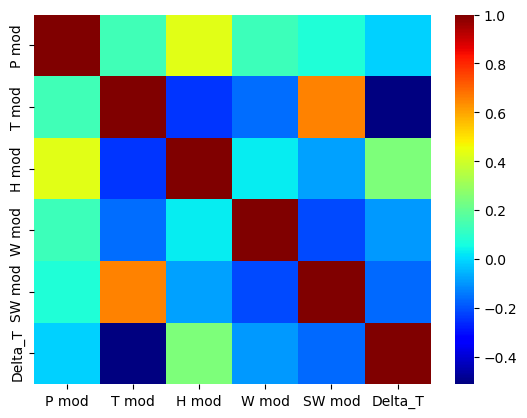

In [1011]:
sns.heatmap(predictive_data[numerical_features + ["Delta_T"]].corr(),cmap="jet")

The modeled variables have only  a  weak negative correlation with the bias in the modeled temperature on one hand, a among themselves in other hand.

In [1013]:
X = predictive_data.loc[:, features]
y = data.loc[:, "Delta_T"]

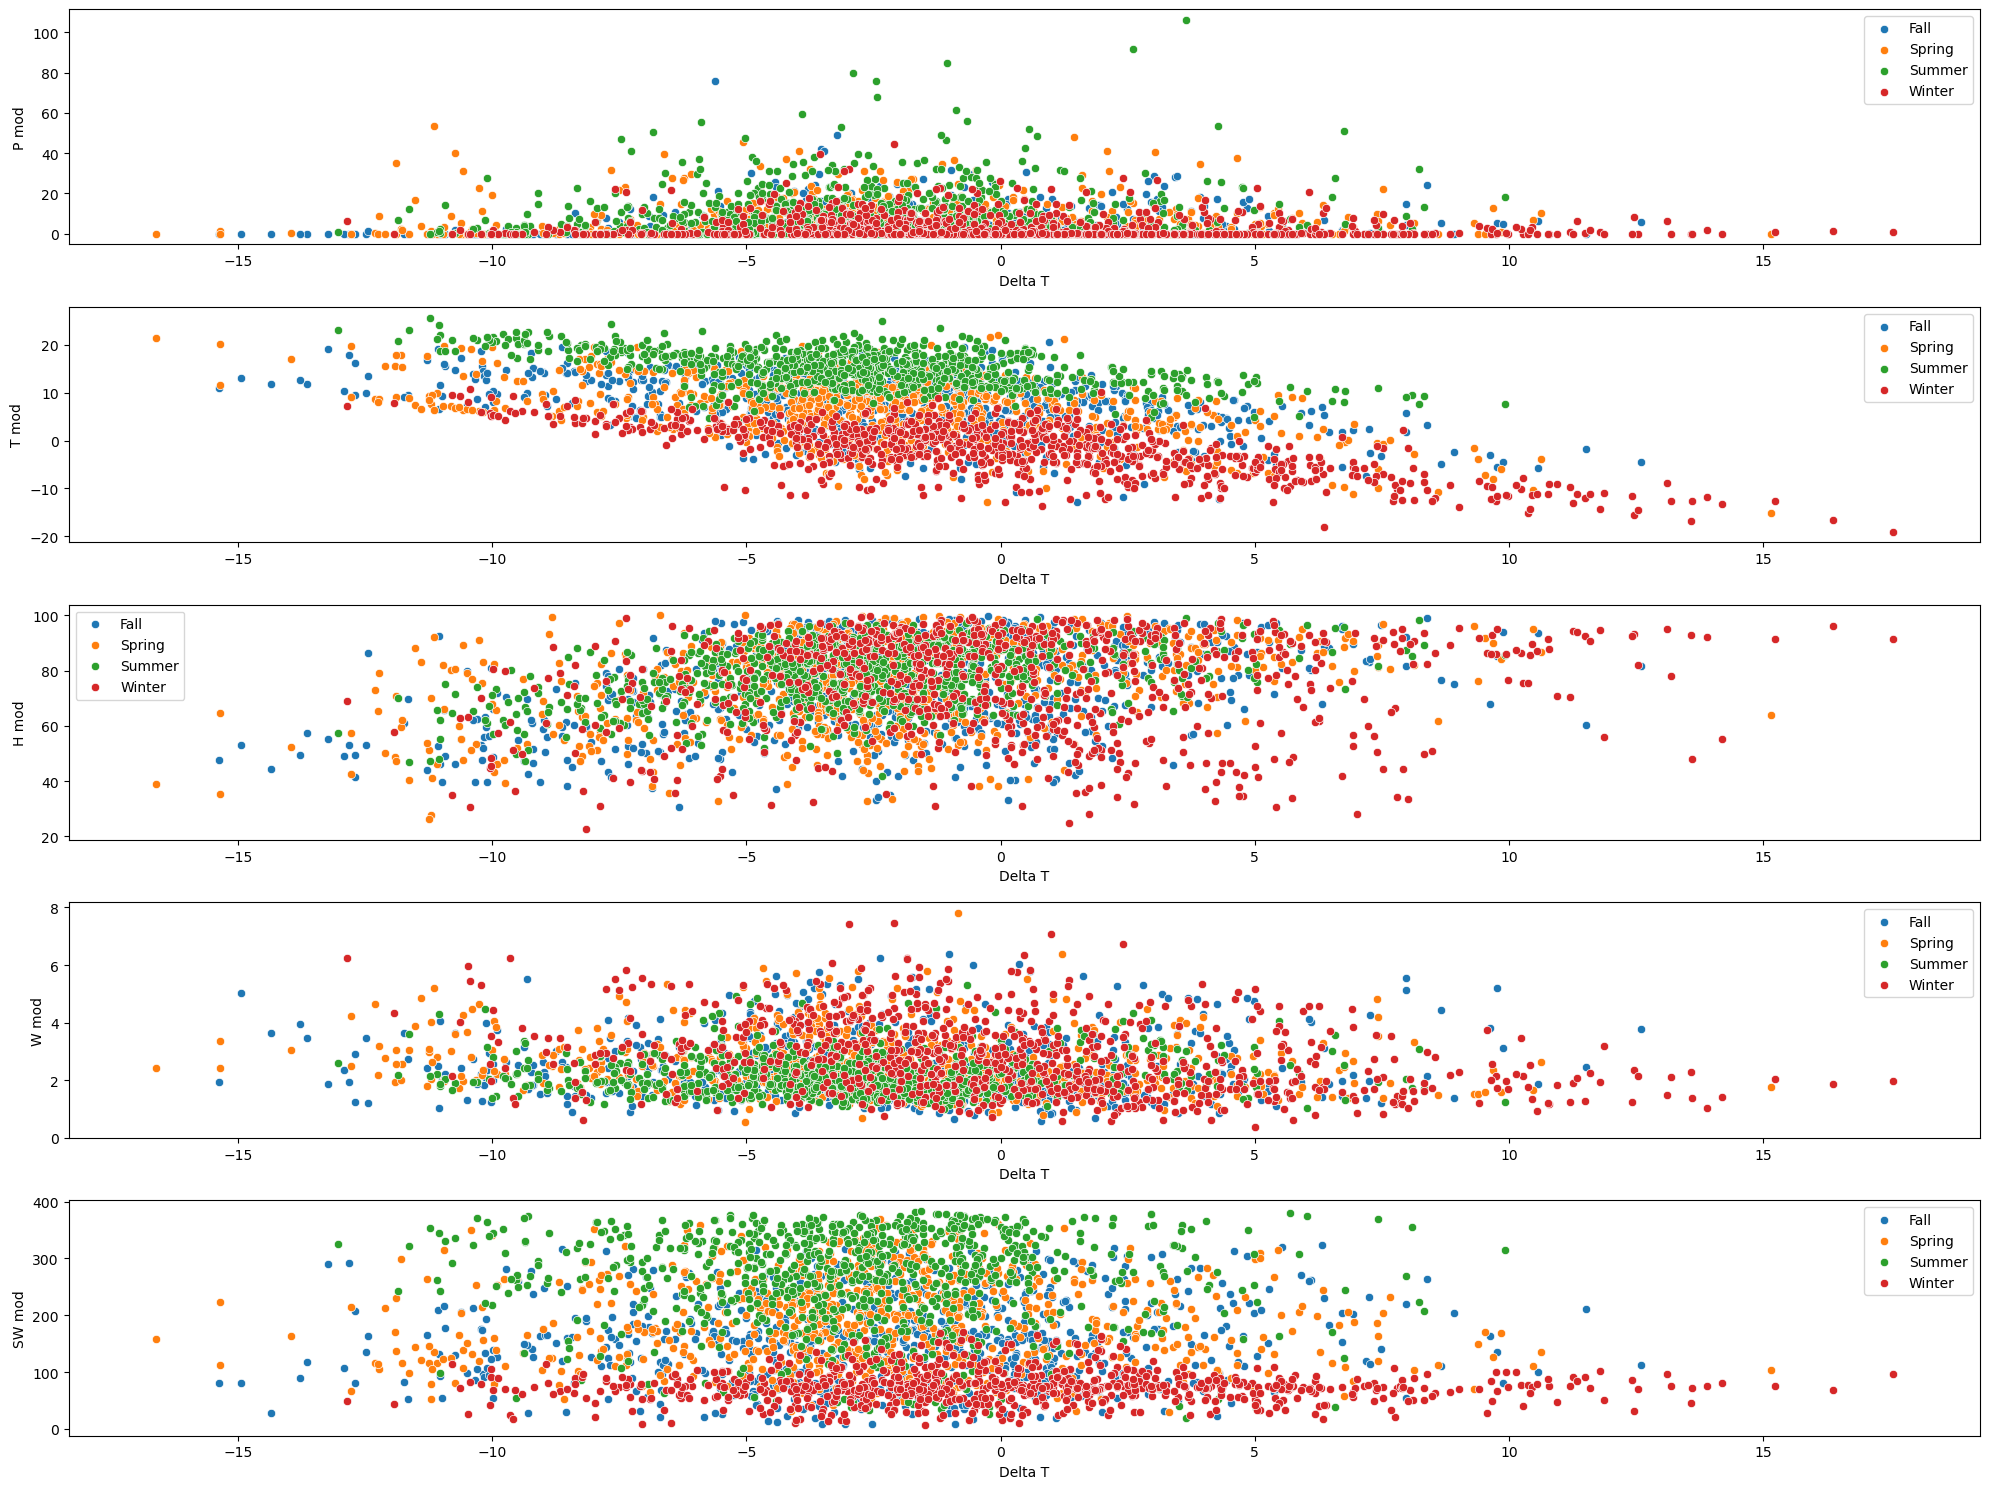

In [1017]:
plt.figure(figsize=(20,15))
group_seasons = station_0_data_indexed_filled.groupby("season")
for idx in range(len(numerical_features)):
    ax = plt.subplot(len(numerical_features), 1, idx+1)
    for label,table in group_seasons:
        sns.scatterplot(y=table[numerical_features[idx]], x = table["Delta_T"],label= label)

    ax.set_xlabel(f"Delta T")
    ax.set_ylabel(f"{features[idx]}")
    plt.tight_layout()
plt.show()


[]

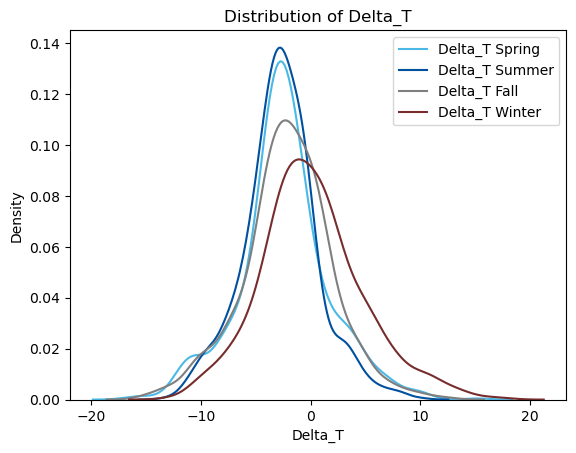

In [1019]:
color_mapping = {"Spring":'#4BB9E6', "Summer":'#0050A0', "Fall":'#7f7f7f',"Winter":"#772D2D"}
for season in seasons:
    sns.kdeplot(data=station_0_data_indexed_filled[station_0_data_indexed["season"] == season], x="Delta_T",label=f"Delta_T {season}",color=color_mapping[season])
plt.legend()
plt.title("Distribution of Delta_T")
plt.plot()

### Visualizing the relation temperature vs time

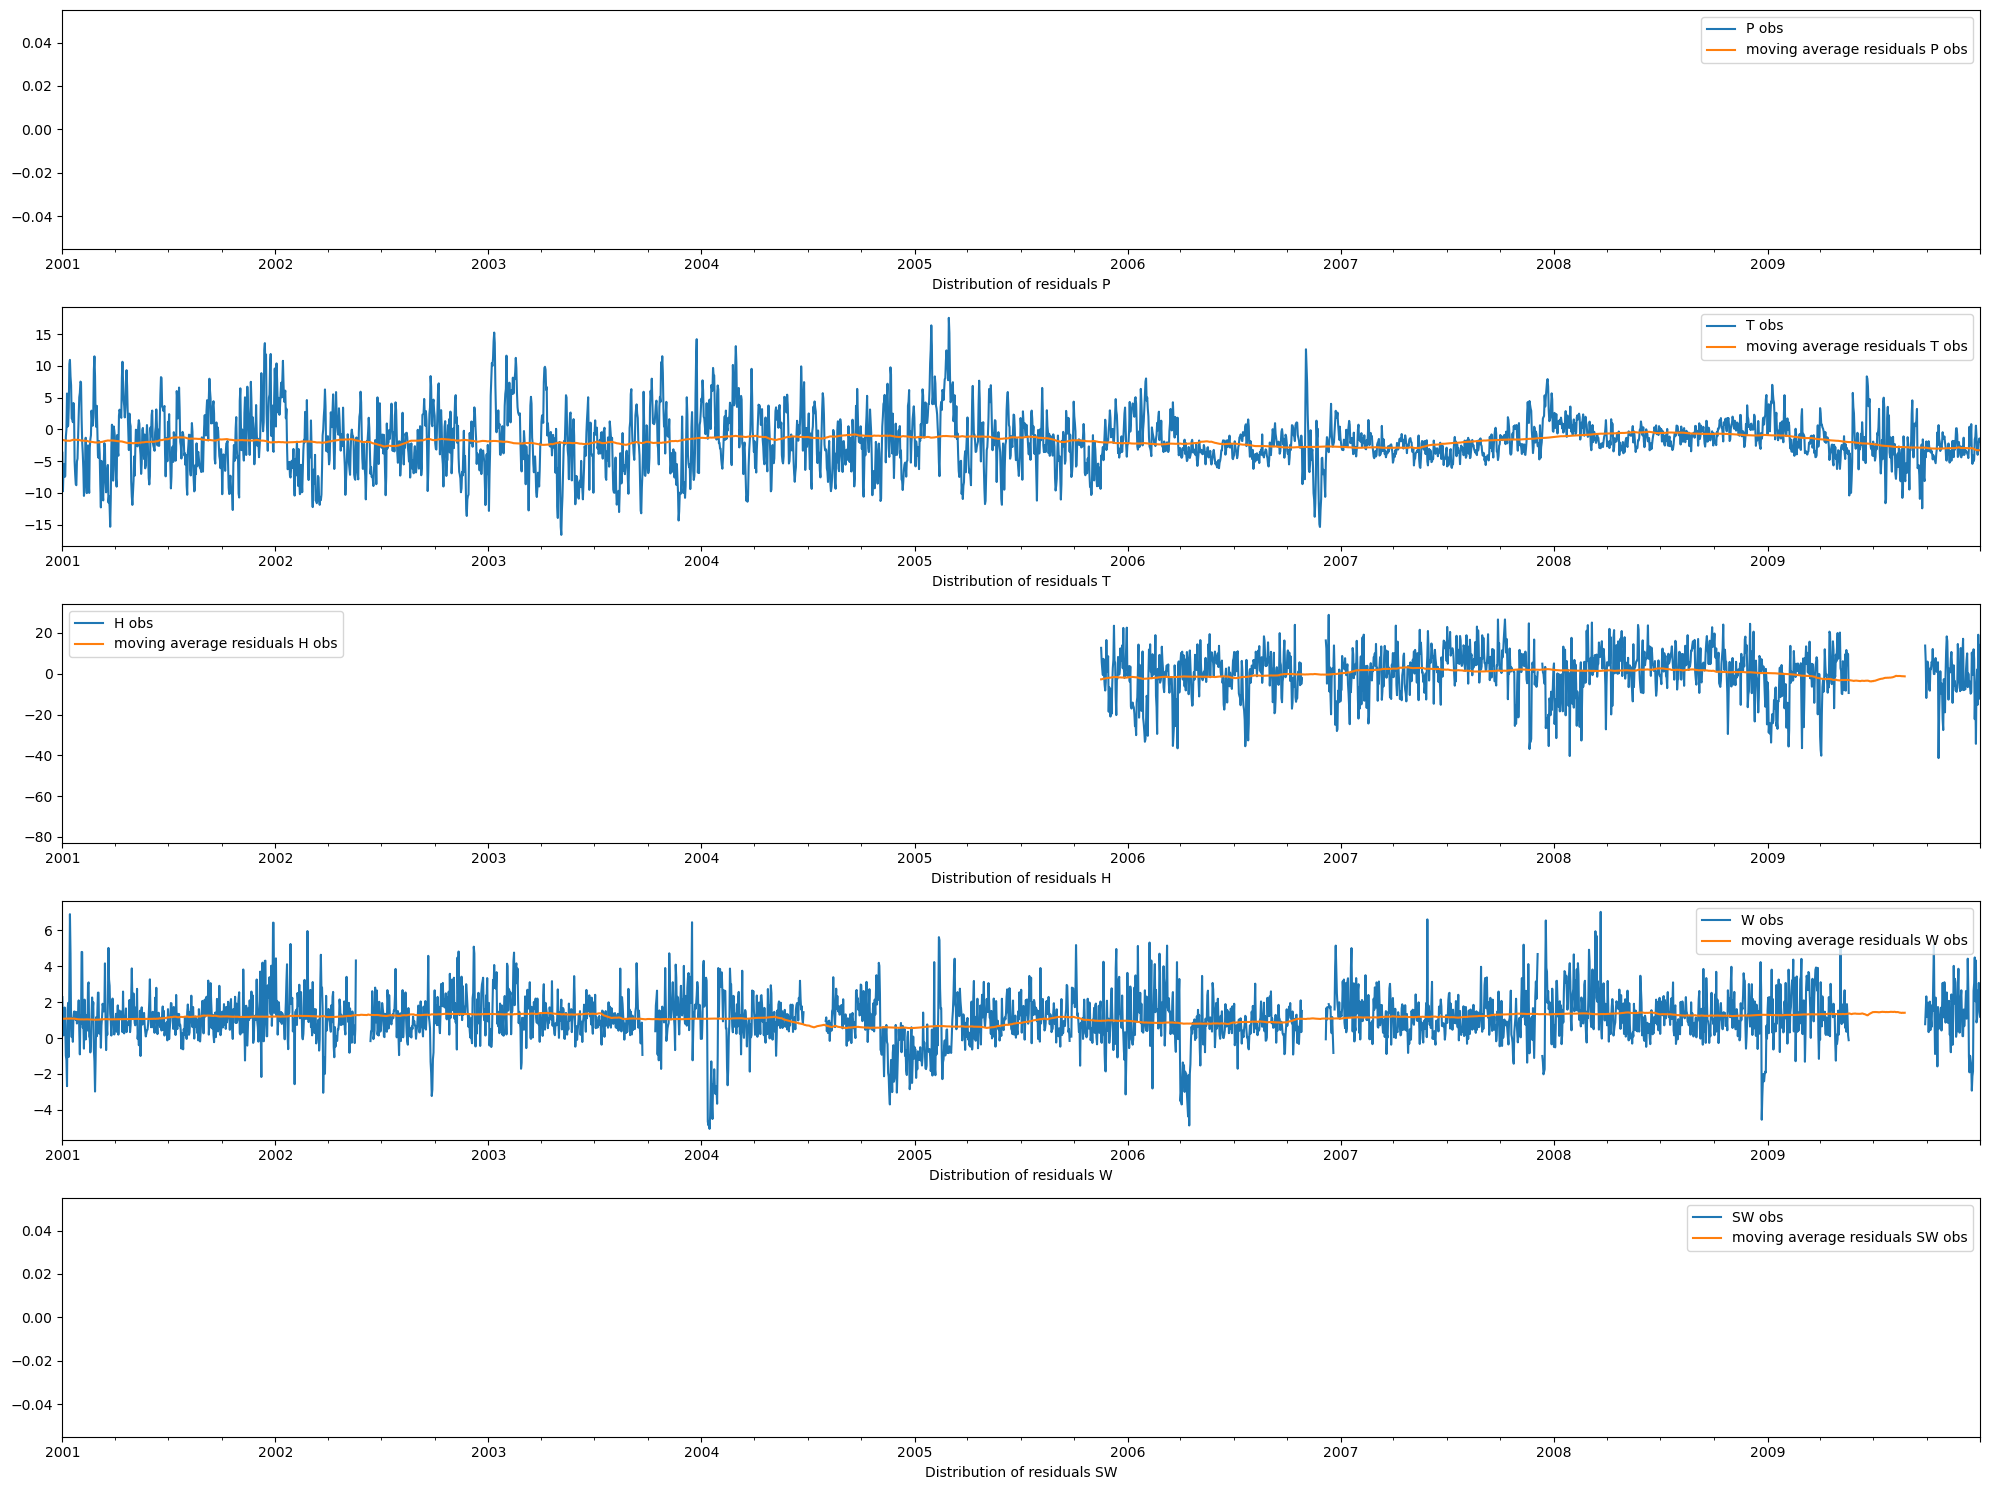

In [1023]:
plt.figure(figsize=(20,15))
for idx in range(len(targets)):
    ax = plt.subplot(len(targets), 1, idx+1)

    station_0_data_indexed_filled[f"Delta_{targets[idx]}"].plot(ax = ax,label=f"{obs_targets[idx]}")
    average  = station_0_data_indexed_filled[f"Delta_{targets[idx]}"].rolling(
        window = WINDOW_SIZE,
            center=True,
            min_periods = WINDOW_SIZE // 2 + 1
    ).mean()
    average.plot(ax = ax,label=f"moving average residuals {obs_targets[idx]}")
    ax.set_xlabel(f"Distribution of residuals {targets[idx]}")
    plt.legend()
    plt.tight_layout()


In [1025]:
X

,P mod,T mod,H mod,W mod,SW mod,season
full_date,,,,,,
2001-01-01,0.00,0.97,32.22,2.67,77.18,Winter
2001-01-02,0.41,4.20,79.75,2.41,69.72,Winter
2001-01-03,2.39,1.47,83.82,3.00,55.23,Winter
2001-01-04,4.32,3.07,67.58,3.73,73.89,Winter
2001-01-05,0.74,4.65,59.15,5.14,74.07,Winter
...,...,...,...,...,...,...
2009-12-27,0.53,-1.38,57.73,3.75,50.83,Winter
2009-12-28,0.04,-2.78,58.51,3.19,66.20,Winter
2009-12-29,3.09,1.32,65.82,2.60,60.28,Winter


In [1027]:
X_dummies = pd.get_dummies(X,prefix="season=",dtype=float)

In [1029]:
X_dummies.head()

,P mod,T mod,H mod,W mod,SW mod,season=_Fall,season=_Spring,season=_Summer,season=_Winter
full_date,,,,,,,,,
2001-01-01,0.00,0.97,32.22,2.67,77.18,0.0,0.0,0.0,1.0
2001-01-02,0.41,4.20,79.75,2.41,69.72,0.0,0.0,0.0,1.0
2001-01-03,2.39,1.47,83.82,3.00,55.23,0.0,0.0,0.0,1.0
2001-01-04,4.32,3.07,67.58,3.73,73.89,0.0,0.0,0.0,1.0
2001-01-05,0.74,4.65,59.15,5.14,74.07,0.0,0.0,0.0,1.0


In [1031]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_dummies)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(pd.DataFrame(y))

In [822]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.33, random_state=42)


In [824]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [826]:
print(f"Score on training data : {lr_model.score(X_train,y_train)}")
print(f"Score on test data : {lr_model.score(X_test,y_test)}")

Score on training data : 0.3605963600956804
Score on test data : 0.36541639136611714


In [828]:
lr_model.coef_

array([[-0.10193888, -0.13506784, -0.29830742, -0.26995473, -0.18646565,
        -0.02004391, -0.10609354, -0.03777356,  0.15689982]])

In [830]:
from sklearn.svm import SVR

svm_model = SVR(kernel="rbf")
svm_model.fit(X_train,y_train.ravel())

SVR()

In [832]:
print(f"Score on training data : {svm_model.score(X_train,y_train)}")
print(f"Score on test data : {svm_model.score(X_test,y_test)}")

Score on training data : 0.5676117519362135
Score on test data : 0.47919155248956846


In [834]:
from sklearn.tree import DecisionTreeRegressor

dT = DecisionTreeRegressor(max_depth=4)
dT.fit(X_train,y_train.ravel())

DecisionTreeRegressor(max_depth=4)

In [840]:
print(f"Score on training data : {dT.score(X_train,y_train)}")
print(f"Score on test data : {dT.score(X_test,y_test)}")

Score on training data : 0.4980208501557314
Score on test data : 0.4321335156436954
